In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import yaml
with open('config.yml') as f:
    config = yaml.load(f)

dwp = config['dcsedwp']
dcgis = config['dcgisprd']

In [2]:
import geopandas as gpd
from shapely.geometry import Point, Polygon

## Connect to DC Data Warehouse (location of 311 data)

In [3]:
import cx_Oracle
dsn_tns = cx_Oracle.makedsn(dwp['host'], dwp['port'], service_name=dwp['service_name'])
dcsedwp = cx_Oracle.connect(dwp['username'], dwp['password'], dsn_tns)

## Load field validation outcomoes and match to predicted probabilities

In [4]:
outcomes = pd.read_csv('data/field_validation_outcomes.csv').drop('Notes', axis=1)

In [5]:
address_to_block = pd.read_csv('data/final_address_to_block_0.csv.gz').drop(['calls', 'activity', 'call_past_3m', 'predicted', 'predicted_prob'], axis=1)
predicted = pd.read_csv('data/final_model_predictions_0.csv')
address_to_block = address_to_block.merge(predicted, how='left', on='GEOID')

In [6]:
by_mar = pd.DataFrame(address_to_block.groupby('MARID')[['GEOID', 'predicted_prob', 'predicted', 'call_past_3m']].max())

## Field Validation Descriptive Stats

In [7]:
validate = outcomes.merge(by_mar, how='left', left_on='ID', right_index=True)

## Distribution of Predicted Probabilities 

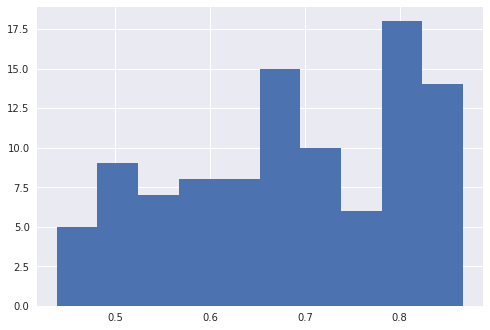

In [8]:
validate.predicted_prob.hist()

## Comparing Predictive Probabilities to Inspection Outcomes

### Q-Q Plot

0.5    0.481481
0.6    0.518519
0.7    0.454545
0.8    0.458333
Name: Burrows_Found, dtype: float64


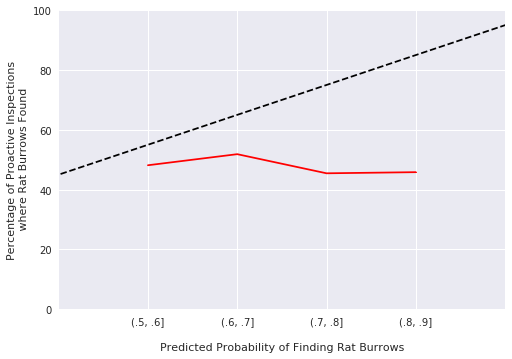

In [9]:
## Predicted vs. Actual Probabilities
bins = 10
binwidth = 1.0/bins
cutpoints = np.arange(-0.0*binwidth, 1.0 + 1.5 * binwidth, binwidth)  # cutpoints between score bins
labs = np.arange(0,1.0+binwidth,binwidth)

validate['pprob_clipped'] = validate['predicted_prob'].clip(0.51,0.9)

z = validate.groupby(pd.cut(x=validate['pprob_clipped'], bins=cutpoints, labels=labs))['Burrows_Found'].mean()
z.index = labs #added to deal with a change in pandas 0.16.1 that creates categorical indices after pd.cut()
print(z[(z.index >= .5) & (z.index <= .8)])

labs = ['(.5, .6]', '(.6, .7]', '(.7, .8]', '(.8, .9]']

fig, ax = plt.subplots()
z[z>0].plot(kind='line',rot=0,marker='.',markersize=2, color='red') 
plt.plot([0,1], [0.05, 1.05], '--', color='black')
ax.set_xlim(.4,.9)
ax.set_ylim(0,1)
ax.set_xlabel('\nPredicted Probability of Finding Rat Burrows')
ax.set_ylabel('Percentage of Proactive Inspections\n where Rat Burrows Found')
ax.set_xticks(np.arange(.5, 1, .1))
ax.set_xticklabels(labs)
ax.set_yticklabels(np.arange(0,120,20))

plt.savefig('figures/field_validation_qqplot.png', bbox_inches = 'tight')

### t-test

In [10]:
from scipy.stats import ttest_ind

call_pprob = validate[validate.pprob_clipped <= .6].Burrows_Found
no_call_pprob = validate[validate.pprob_clipped > .8].Burrows_Found

print('Percent of field validations where rats were found: '+str(100 * validate.Burrows_Found.mean()))
ttest_ind(call_pprob, no_call_pprob)

Percent of field validations where rats were found: 48.0


Ttest_indResult(statistic=0.16208046719210259, pvalue=0.87190900942446536)

### ROC Curve

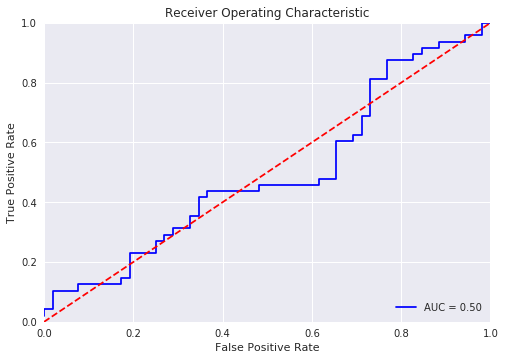

In [11]:
from sklearn.metrics import roc_curve, auc

uninspected = validate[validate.call_past_3m==0].copy()
## Receiver Operating Characteristic
burrows = validate[validate['Burrows_Found'].isnull()==False]
fpr, tpr, threshold = roc_curve(burrows['Burrows_Found'], burrows['predicted_prob'])

fig, ax = plt.subplots()
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.savefig('figures/field_validation_rocauc.png')

## Compare Predicted Probabilities to Data from 311

In [12]:
blocks = gpd.read_file('data/Census_Blocks__2010.geojson')
blocks = blocks[['GEOID', 'BLOCK', 'BLKGRP', 'P0010001', 'SqMiles', 'ACRES', 'geometry']]

blks = blocks[['GEOID', 'P0010001', 'SqMiles']].set_index('GEOID')
blks['pop_density'] = blks['P0010001']*1.0/blks['SqMiles']
blks['tot_pop'] = blks['P0010001']
blks = blks.drop(['P0010001', 'SqMiles'], axis=1)

In [13]:
print ('Started pulling data at '+time.strftime("%a, %d %b %Y %H:%M:%S +0000", time.localtime()))  
rats = pd.read_sql('''
select 
sr_history_id
, service_request_id__c
, servicecode
, servicecodedescription
, serviceorderdate
, serviceorderstatus
, inspectiondate
, resolution
, resolutiondate
, servicenotes
, ward
, longitude
, latitude
from EDW_CIRM.VW_SERVICE_REQUESTS_DC_MSSQL
where serviceorderdate >= TO_DATE('2017-10-10', 'yyyy-mm-dd')
and serviceorderdate <= TO_DATE('2017-11-20', 'yyyy-mm-dd')
and (servicecodedescription = 'Rat Abatement'
or servicecodedescription = 'Rodent Inspection and Treatment')
and longitude is not null and latitude is not null
and cast(longitude as float) < 0 and cast(latitude as float) > 0
''', dcsedwp)
print ('Finished pulling data at '+time.strftime("%a, %d %b %Y %H:%M:%S +0000", time.localtime()))

Started pulling data at Wed, 11 Jul 2018 21:53:36 +0000
Finished pulling data at Wed, 11 Jul 2018 21:53:54 +0000


In [14]:
def outcome(x):
    if x is None:
        return None
    elif 'baited' in x.lower():
        return 1
    elif 'treatment' in x.lower():
        return 1
    elif 'treated' in x.lower():
        return 1
    elif 'found rat burrows' in x.lower():
        return 1
    elif 'found mice' in x.lower():
        return 0
    elif 'found mice in home' in x.lower():
        return 0
    elif 'no evidence' in x.lower():
        return 0
    elif 'no rat' in x.lower():
        return 0
    elif 'no rats' in x.lower():
        return 0
    elif 'no rat burrow' in x.lower():
        return 0
    elif 'no rat burrows' in x.lower():
        return 0
    elif 'no rat burrows' in x.lower():
        return 0
    elif 'no rats burrows' in x.lower():
        return 0
    elif 'no rat holes' in x.lower():
        return 0
    elif 'no burrows' in x.lower():
        return 0
    elif 'no rat activity' in x.lower():
        return 0
    elif 'no rodent activity' in x.lower():
        return 0
    elif 'no activity' in x.lower():
        return 0
    elif 'no visible' in x.lower():
        return 0
    elif 'gate locked' in x.lower():
        return 0
    elif 'fenced and no permission' in x.lower():
        return 0
    elif 'no access' in x.lower():
        return 0

In [15]:
rats['week'] = pd.to_datetime(rats.SERVICEORDERDATE).dt.week
rats['year'] = pd.to_datetime(rats.SERVICEORDERDATE).dt.year
rats['month'] = pd.to_datetime(rats.SERVICEORDERDATE).dt.month

In [16]:
rats['calls'] = 1
rats['activity'] = rats['SERVICENOTES'].apply(outcome)
closed = rats[rats['SERVICEORDERSTATUS']=='Closed']
closed = closed[closed.SERVICENOTES.isnull()==False]

In [17]:
def inspector(x):
    if 'D Broomfield' in x:
        return 'Broomfield'
    elif 'Herrington' in x:
        return 'Herrington'
    elif 'Redman' in x:
        return 'Redman'
    elif 'G Curtis' in x:
        return 'Curtis'
    elif 'A Cuff' in x:
        return 'Cuff'
    elif 'M Parker' in x:
        return 'Parker'
    elif 'L Rogers' in x:
        return 'Rogers'
    elif 'G Cornes' in x:
        return 'Cornes'
    
closed['inspector'] = closed['SERVICENOTES'].apply(inspector)
inspectors = pd.get_dummies(closed.inspector, prefix='inspector')
closed = closed.merge(inspectors, how='left', left_index=True, right_index=True)

In [18]:
## Create geometry for 311 data
geometry = [Point(xy) for xy in zip(closed.LONGITUDE.apply(float), closed.LATITUDE.apply(float))]
crs = {'init': 'epsg:4326'}
points = gpd.GeoDataFrame(closed, crs=crs, geometry=geometry)

## Join rats data to Census blocks
geo_rats = gpd.sjoin(blocks, points, how='left', op='intersects')

In [19]:
grouped = pd.DataFrame(geo_rats.groupby('GEOID')[['calls', 'activity', 'WARD']].max())
grouped = grouped.fillna(0)
predicted['GEOID'] = predicted.GEOID.astype(str)
pred_to_blocks = blocks.merge(predicted[['GEOID', 'predicted_prob', 'call_past_3m']], how='left', on='GEOID')
validate_311 = pred_to_blocks.merge(grouped, how='left', left_on='GEOID', right_index=True)

0.0    0.000000
0.1    0.145833
0.2    0.373134
0.3    0.359375
0.4    0.460317
0.5    0.558824
0.6    0.671642
0.7    0.756098
0.8    0.742857
0.9    1.000000
Name: activity, dtype: float64


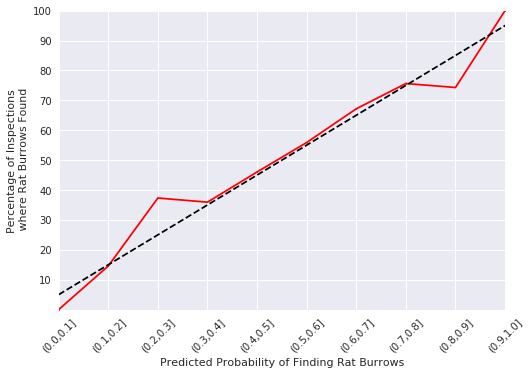

In [20]:
## Predicted vs. Actual Probabilities
bins = 10
binwidth = 1.0/bins
cutpoints = np.arange(0.0*binwidth, 1 + binwidth, binwidth)  # cutpoints between score bins
labs = np.arange(0,1.0,binwidth)

inspected = validate_311.loc[validate_311.calls==1].copy()
z = inspected.groupby(pd.cut(x=inspected['predicted_prob'], bins=cutpoints))['activity'].mean()
z.index = labs #added to deal with a change in pandas 0.16.1 that creates categorical indices after pd.cut()
print(z)

labs = ['(0.0,0.1]', '(0.1,0.2]', '(0.2,0.3]', '(0.3,0.4]', '(0.4,0.5]', '(0.5,0.6]', '(0.6,0.7]', '(0.7,0.8]', '(0.8,0.9]', '(0.9,1.0]']

fig, ax = plt.subplots()
z.plot(kind='line',rot=0,marker='.',markersize=2, color='red') 
plt.plot([0,1], [0.05, 1.05], '--', color='black')
ax.set_xlabel('Predicted Probability of Finding Rat Burrows')
ax.set_ylabel('Percentage of Inspections\n where Rat Burrows Found')
ax.set_xticks(np.arange(0,1,.1))
ax.set_yticks(np.arange(.1,1.1,.1))
ax.set_xticklabels(labs)
plt.xticks(rotation=45)
ax.set_yticklabels(np.arange(10,110,10))
ax.set_xlim(0,.9)
ax.set_ylim(0,1)
#ax.set_title('Figure 2: Predicted Probabilities Compared\n to Outcomes of 311 Requests from Oct. 10 to Nov. 20'.format(bins))

plt.savefig('figures/311_validation_qqplot.png', bbox_inches = 'tight')

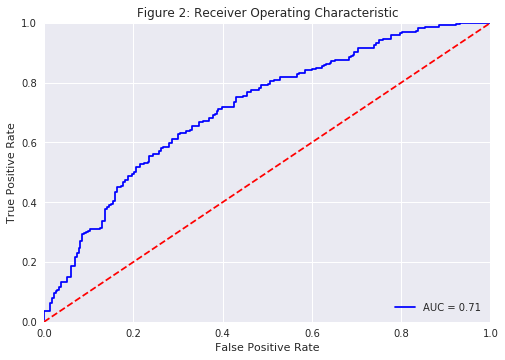

In [21]:
from sklearn.metrics import roc_curve, auc

## Receiver Operating Characteristic
fpr, tpr, threshold = roc_curve(inspected['activity'], inspected['predicted_prob'])

fig, ax = plt.subplots()
roc_auc = auc(fpr, tpr)
plt.title('Figure 2: Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.savefig('figures/311_validation_rocauc.png')

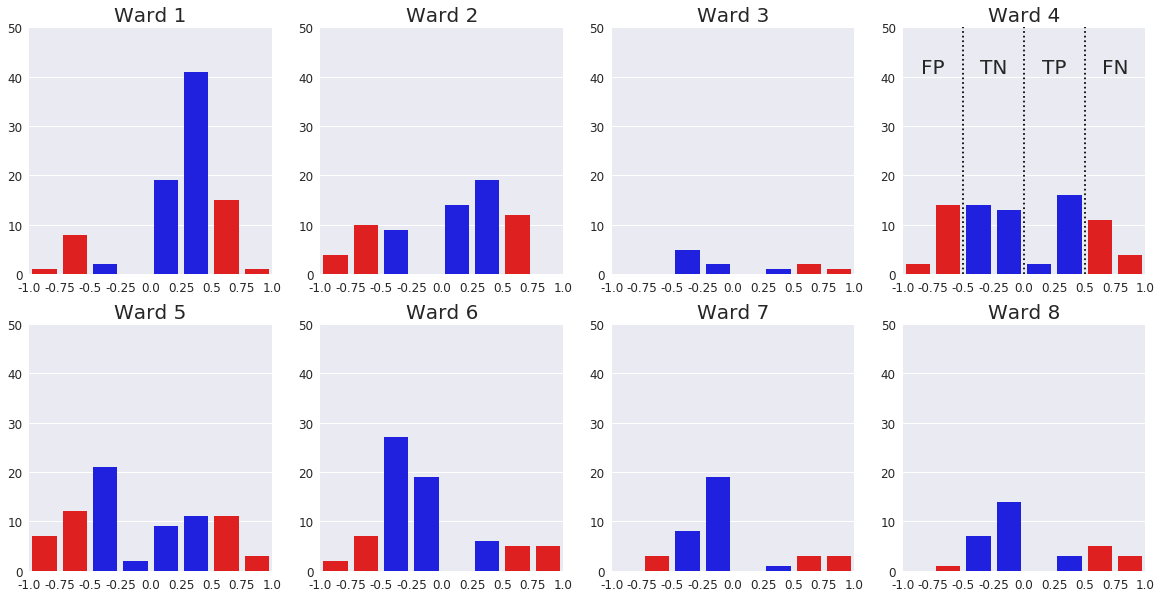

In [22]:
inspected['error'] = inspected.activity - inspected.predicted_prob
inspected['abs_error'] = abs(inspected.activity - inspected.predicted_prob)
inspected['predicted'] = 1 * (inspected.predicted_prob > .5)

bins = 10
binwidth = 1.0/bins
cutpoints = np.arange(-1,1.25,0.25)  # cutpoints between score bins
labs = np.arange(-1,1,0.25)

fig = plt.figure(figsize = (20, 10))
for ward in np.sort(inspected.WARD.unique()):
    ax = fig.add_subplot(2,4,int(ward))
    w = inspected.loc[inspected.WARD == ward]
    w2 = inspected.loc[(inspected.WARD == ward) & (inspected.activity != inspected.predicted)]
    z = w.groupby(pd.cut(x=w['error'], bins=cutpoints))['error'].count()
    z2 = w2.groupby(pd.cut(x=w2['error'], bins=cutpoints))['error'].count()
    sns.barplot(z.index, z.values, color = 'blue', ax = ax)
    sns.barplot(z2.index, z2.values, color = 'red', ax = ax)    
    ax.set_title('Ward '+str(ward), fontsize = 20)
    ax.set_ylim(0,50)
    ax.set_xlabel('')
    ax.set_xticks(np.arange(-0.5, 8.5, 1))
    ax.set_xticklabels(np.arange(-1, 1.25, .25))
    plt.tick_params(which = 'major', labelsize = 12)
    
    if ward == '4':
        ax.vlines(x = [1.5, 3.5, 5.5], ymin = 0, ymax = 50, linestyles = 'dotted')
        ax.annotate('FP', xy = (0.5, 40), fontsize = 20, horizontalalignment='center', verticalalignment='bottom')
        ax.annotate('TN', xy = (2.5, 40), fontsize = 20, horizontalalignment='center', verticalalignment='bottom')
        ax.annotate('TP', xy = (4.5, 40), fontsize = 20, horizontalalignment='center', verticalalignment='bottom')
        ax.annotate('FN', xy = (6.5, 40), fontsize = 20, horizontalalignment='center', verticalalignment='bottom')

plt.savefig('figures/error-by-ward.png', bbox_inches = 'tight')